# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 43 kB/s  eta 0:00:01�████████████       | 24.0 MB 1.1 MB/s eta 0:00:07
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 7.3 kB/s eta 0:00:01


In [ ]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt

import category_encoders as ce

from scipy.stats import mode

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,10)

### Чтение данных и первичный анализ

In [ ]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    print('Please, chech path')

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Первичные наблюдения:

Скорее всего, нам не потребуются следующие столбцы (так как они связаны либо с датой объявления, либо с данными владельца анкеты):
- DateCrawled
- DateCreated
- PostalCode
- LastSeen

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Целевой признак (цена) есть по всем объектам. По части столбцов есть пропуски. Более детальро посмотрим далее

In [ ]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наблюдения:
 - макс год регистрации 9999 - ошибка в данных (как и минимальный год)
 - макс мощность 20 000 л.с - выглядит подозрительно - надо проверить
 - число фотографий - либо 0, либо Nan - столбец можно будет удалить из-за неинформативности
 - надо преобразовать тип данных по столбцам год регистрации и месяц в int
 - посмотреть тип топлива (gasoline and petrol is the same)

Самая популярная марка - Фольксваген (модель гольф). Правдоподобно) пробег ограничен значением в 150 тыс км и макс цена в 20 тыс евро

### Предобработка данных

Найдем максимальную дату скачивания анкеты из базы

In [ ]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

Дата регистрации:

Получается, что дата регистрации автомобиля не модет быть старше 7 апреля 2016 года

In [ ]:
#посмотрим на объявления позднее 07/04/2016
data.query('RegistrationYear >= 2016 & RegistrationMonth >= 4').count()

DateCrawled          13560
Price                13560
VehicleType             57
RegistrationYear     13560
Gearbox              12368
Power                13560
Model                11864
Kilometer            13560
RegistrationMonth    13560
FuelType              8179
Brand                13560
Repaired              8205
DateCreated          13560
NumberOfPictures     13560
PostalCode           13560
LastSeen             13560
dtype: int64

In [ ]:
#зафиксируем размер исходного датасета, чтобы потом понять процент удаленных данных
old_shape = data.shape[0]
old_shape

354369

Удалим объявления позднее 04/2016:

In [ ]:
data = data.query('RegistrationYear <= 2016')

In [ ]:
#также удалим объявления 2016 года с регистрацией начиная с 04/2016
#для этого присвоим таким объявлениям отриц цену и потом удалим строки с отриц ценами
data.loc[(data['RegistrationYear'] == 2016) & (data['RegistrationMonth'] >=4), 'Price'] = -1
data = data.query('Price >= 0')

Пока работаем с датой регистрации - удалим строки со старой датой регистрации, считая их выборосами

In [ ]:
data = data.query('RegistrationYear > 1900')
data['RegistrationYear'].quantile(0.005)

1971.0

Удалим автомобиль с годом регистрации младше 1972

In [ ]:
data = data.query('RegistrationYear >= 1972')

Text(0, 0.5, 'Количество авто')

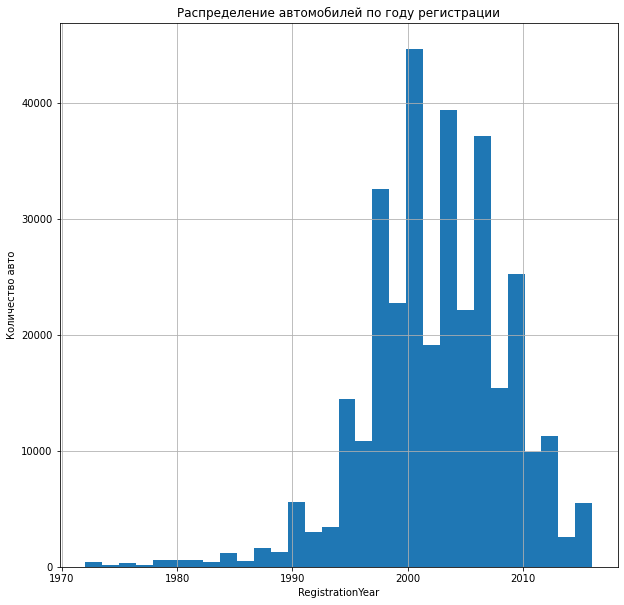

In [ ]:
plt.grid()

plt.hist(data['RegistrationYear'], bins=30);
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('RegistrationYear')
plt.ylabel('Количество авто')

Посмотрим на распределение цен:

Text(0, 0.5, 'Количество авто')

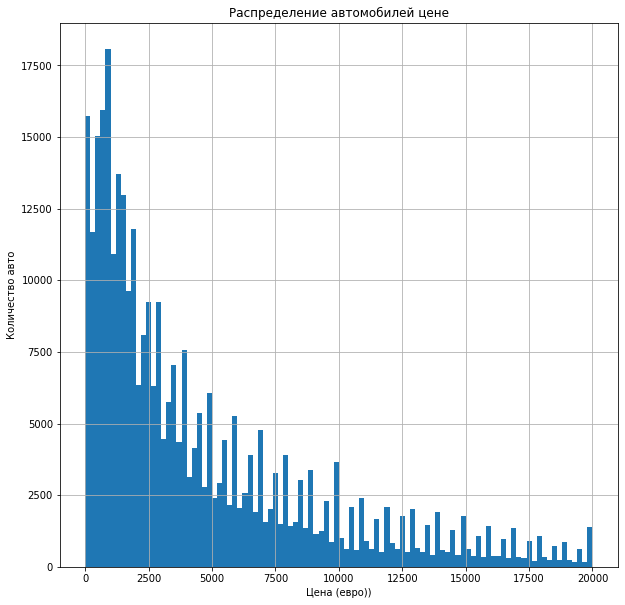

In [ ]:
plt.grid()

plt.hist(data['Price'], bins=100);

plt.title('Распределение автомобилей цене')
plt.xlabel('Цена (евро))')
plt.ylabel('Количество авто')

Удалим выбросы (слишком низкие и слишком высокие цены)

In [ ]:
data['Price'].quantile(0.05)

200.0

In [ ]:
data[data['Price'] < 200].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
150611,2016-04-03 21:37:20,5,small,1993,NaN,0,polo,150000,0,NaN,volkswagen,yes,2016-04-03 00:00:00,0,45721,2016-04-05 22:18:18
297682,2016-03-14 21:39:54,0,NaN,1995,NaN,0,3er,125000,0,NaN,bmw,NaN,2016-03-14 00:00:00,0,84098,2016-04-06 12:15:21
303991,2016-03-27 19:54:50,180,NaN,2000,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-03-27 00:00:00,0,38465,2016-04-05 18:45:51
116034,2016-04-07 14:07:17,0,sedan,1999,NaN,125,a3,150000,8,petrol,audi,no,2016-04-07 00:00:00,0,35415,2016-04-07 14:07:17
267448,2016-03-14 10:42:13,150,wagon,1997,manual,90,NaN,150000,7,NaN,ford,no,2016-03-14 00:00:00,0,21684,2016-03-15 23:46:21
172125,2016-03-18 10:48:43,170,NaN,1995,auto,101,astra,150000,0,NaN,opel,yes,2016-03-18 00:00:00,0,23847,2016-04-05 22:16:35
49618,2016-03-24 21:52:20,0,NaN,2000,NaN,0,corsa,20000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,96465,2016-03-27 19:45:15
262497,2016-03-21 19:52:41,25,NaN,2007,NaN,0,passat,5000,0,NaN,volkswagen,NaN,2016-03-21 00:00:00,0,98596,2016-04-06 22:46:47
188686,2016-03-15 20:45:05,150,NaN,2000,manual,60,polo,150000,3,petrol,volkswagen,no,2016-03-15 00:00:00,0,25878,2016-03-20 18:48:29
309247,2016-04-02 17:54:54,13,NaN,1995,NaN,0,golf,5000,0,NaN,volkswagen,NaN,2016-04-02 00:00:00,0,49163,2016-04-06 17:18:00


Среди машин с низкой ценой есть как и правдободобные вариант (старые, с большим пробегом, после ремонта - цена таких машин скорее всего очень низкая, так есть и хорошие машины (без ремонта, небольшой пробег - но цена практически 0). Так как мы готовим датасет к предсказанию правдоподобной цены, то проведем нижнюю границу в 100 евро, тем самым отбросим выбросы с нулевой ценой (порядка 3% данных)

Удалим автомобили с ценой ниже 100 евро

In [ ]:
data = data.query('Price >= 100')

Text(0, 0.5, 'Количество авто')

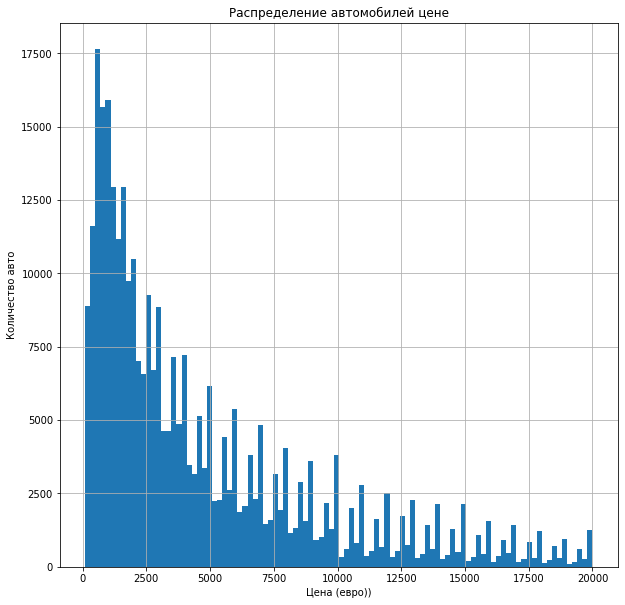

In [ ]:
plt.grid()

plt.hist(data['Price'], bins=100);

plt.title('Распределение автомобилей цене')
plt.xlabel('Цена (евро))')
plt.ylabel('Количество авто')

Ограничивать справа смыла нет, так как у нас макс цена в 20 тыс евро. Это не походе на выброс в данных

Посмотрим на тип топлива:

In [ ]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заменим gasoline на petrol, так как это одно и тоже

In [ ]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [ ]:
data['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Посмотрим на пропуски в данных

In [ ]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.042660
RegistrationYear     0.000000
Gearbox              0.043065
Power                0.000000
Model                0.043973
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.064790
Brand                0.000000
Repaired             0.174132
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Самые значимые пропуски в следуюзих столбцах:
- 3.5% пропусков в столбце тип кузова
- 16% пропусков в столбце repair
- 5% в столбце тип топлива
- по 4% в тип коробки и модели

Пропуски по типу кузова (категориальная переменная) заполним значением unknown

In [ ]:
data.loc[data['VehicleType'].isna(), 'VehicleType'] = 'unknown'

Аналогично поступим со столбоцом Repaired

In [ ]:
data.loc[data['Repaired'].isna(), 'Repaired'] = 'unknown'

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Заполнение пропусков одной "заглушкой" - верно.
</div>

Пропуски по модели удалим, так как модель машины важна нам для прогнозирования цены

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data = data.dropna(subset=['Model'])

In [ ]:
data[data['Model'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Удаление пропусков по модели выпонено корректно

Остались пропуски по типу топлива и коробки передач. Здест пропуски заполним модой по группам модель-бренд

In [ ]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.000000
RegistrationYear     0.000000
Gearbox              0.037856
Power                0.000000
Model                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.054277
Brand                0.000000
Repaired             0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [ ]:
data.groupby(['Brand','Model']).agg({'Gearbox' : pd.Series.mode})

Gearbox
Brand      Model           
alfa_romeo 145       manual
           147       manual
           156       manual
           159       manual
           other     manual
...                     ...
volvo      v40       manual
           v50       manual
           v60       manual
           v70       manual
           xc_reihe    auto

[297 rows x 1 columns]

In [ ]:
data['Gearbox'] = data.groupby(['Brand','Model']).Gearbox.apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
data[data['Gearbox'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Все пропуски по трансмиссии заполнены модой по группе. Сделаем аналогично с типом топлива

In [ ]:
data['FuelType'] = data.groupby(['Brand','Model']).FuelType.apply(lambda x: x.fillna(x.mode()[0]))

In [ ]:
data[data['FuelType'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Пропуски по типу топлива заполнены

Убедимся, что пропусков в данных нет:

In [ ]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Также при первичном осмотре данных были замечены выбросы по мощности. Посмотрим более детально:

Text(0, 0.5, 'Количество авто')

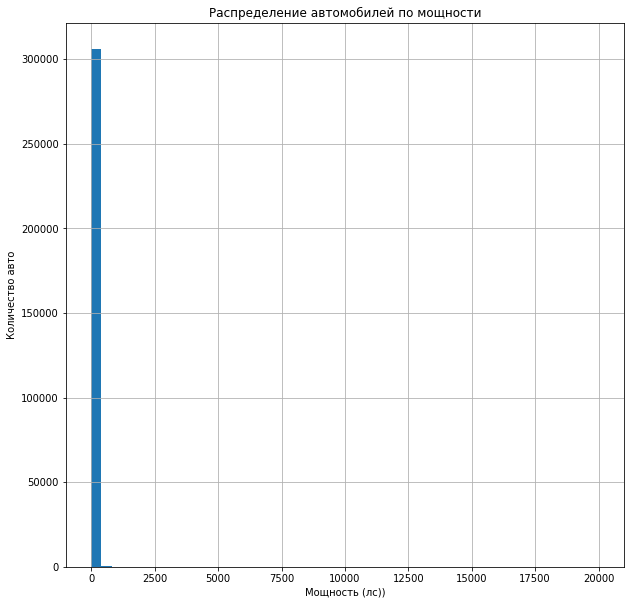

In [ ]:
plt.grid()

plt.hist(data['Power'], bins=50);

plt.title('Распределение автомобилей по мощности')
plt.xlabel('Мощность (лс))')
plt.ylabel('Количество авто')

In [ ]:
data[data['Power'] > 1000]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,unknown,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,unknown,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,petrol,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,petrol,audi,unknown,2016-03-05 00:00:00,0,7646,2016-03-07 16:17:01
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,unknown,2016-03-13 00:00:00,0,24568,2016-04-06 15:17:39
348968,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04 00:00:00,0,28259,2016-04-04 18:53:25
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,petrol,opel,no,2016-03-07 00:00:00,0,66117,2016-03-09 12:47:08


In [ ]:
data['Power'].quantile(0.995)

333.0

In [ ]:
data['Power'].quantile(0.025)

0.0

Видим, что можно ограничить мощность в датасете значеним в 350 лс, а нижняя граница должна быть больше 0 лс

In [ ]:
data = data.query('0 < Power < 350')

Text(0, 0.5, 'Количество авто')

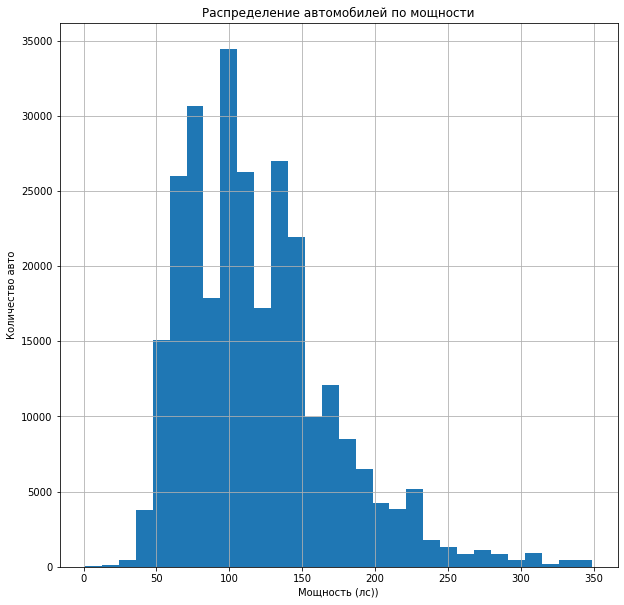

In [ ]:
plt.grid()

plt.hist(data['Power'], bins=30);

plt.title('Распределение автомобилей по мощности')
plt.xlabel('Мощность (лс))')
plt.ylabel('Количество авто')

На этом предобработка данных завершена. Посмотрим на то, какую часть данных от исходного датасета мы удалили:

In [ ]:
print(f'Было удалено {(1 - (data.shape[0] / old_shape))*100:.2f}% данных от исходного датасета')

Было удалено 21.12% данных от исходного датасета


Мы удалили порядка 20% в данных - это данные с неадекватно низкой ценой, выбросами по мощности, с пропусками по модели и некорректным годом регистрации. Пропуски по коробке и типу топлива были заполнены модой по группе

Проверим, нет ли МК в признаках

In [ ]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.580858,0.508472,-0.397632,0.066454,NaN,0.063334
RegistrationYear,0.580858,1.000000,0.156009,-0.370063,0.028869,NaN,0.034384
Power,0.508472,0.156009,1.000000,0.108153,0.042142,NaN,0.054804
Kilometer,-0.397632,-0.370063,0.108153,1.000000,-0.017548,NaN,-0.011249
RegistrationMonth,0.066454,0.028869,0.042142,-0.017548,1.000000,NaN,0.002682
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.063334,0.034384,0.054804,-0.011249,0.002682,NaN,1.000000


Видим, что явной корреляции между признаками нет. На таргет ожидаемо больше всего влияют год, пробег и мощность

## Обучение моделей

Для обучения модели следющие столбцы не несут смысловой нагрузки:
- DateCrawled
- DateCreated
- PostalCode
- LastSeen
- NumberOfPictures (везде 0)
- RegistrationMonth

Поэтому удалим данные столцы из датасета

In [ ]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'])

In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Нам потребуются 3 выборки:
- train (60%)
- valid (20%)
- test (20%) - для финальной оценки лучшей модели

In [ ]:
data_train, data_temp = train_test_split(data, test_size=0.4, random_state=12345)

In [ ]:
#checking the size of df_train
data_train.shape[0] / data.shape[0]

0.6

In [ ]:
#divide df_temp at equal datasets (valid and test)
data_valid, data_test = train_test_split(data_temp, test_size=0.5, random_state=12345)

In [ ]:
print(data_train.shape[0] / data.shape[0])
print(data_valid.shape[0] / data.shape[0])
print(data_test.shape[0] / data.shape[0])

0.6
0.2
0.2


Разделение на 3 выборки проведено корректно

In [ ]:
features_train = data_train.drop(columns='Price')
target_train = data_train.Price

print(features_train.shape)
print(target_train.shape)

(167712, 9)
(167712,)


In [ ]:
features_valid = data_valid.drop(columns='Price')
target_valid = data_valid.Price

print(features_valid.shape)
print(target_valid.shape)

(55904, 9)
(55904,)


In [ ]:
features_test = data_test.drop(columns='Price')
target_test = data_test.Price

print(features_test.shape)
print(target_test.shape)

(55904, 9)
(55904,)


### Linear Model

Перед обучением модели необходимо катеориальные признаки с помощью OHE энкодера преобразовать в числовые

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167712 entries, 141348 to 275821
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       167712 non-null  object
 1   RegistrationYear  167712 non-null  int64 
 2   Gearbox           167712 non-null  object
 3   Power             167712 non-null  int64 
 4   Model             167712 non-null  object
 5   Kilometer         167712 non-null  int64 
 6   FuelType          167712 non-null  object
 7   Brand             167712 non-null  object
 8   Repaired          167712 non-null  object
dtypes: int64(3), object(6)
memory usage: 12.8+ MB


In [ ]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [ ]:
features_train_ridge = features_train.copy()
features_valid_ridge = features_valid.copy()
features_test_ridge = features_test.copy()

In [ ]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
#encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
#encoder_ohe.fit(features_train_ridge[ohe_features_ridge])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
#features_train_ridge[
    #encoder_ohe.get_feature_names_out()
#] = encoder_ohe.transform(features_train_ridge[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
#features_train_ridge = features_train_ridge.drop(ohe_features_ridge, axis=1)

#features_train_ridge.head()

In [ ]:
#загружаем TargetEncoder
encoder_target = ce.TargetEncoder()

#настраиваем его на обучающей выборке
encoder_target.fit(features_train_ridge[ohe_features_ridge], target_train)

#трансформируем категориальные переменные
features_train_ridge[encoder_target.get_feature_names_out()] = \
encoder_target.transform(features_train_ridge[ohe_features_ridge])

features_train_ridge.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
141348,6355.741829,1993,4344.442005,140,5428.054387,150000,4928.704136,6718.237413,5550.867867
203609,5220.216548,2002,4344.442005,131,2967.705317,150000,4928.704136,3614.549669,5550.867867
91591,2927.090187,2001,4344.442005,75,2176.326230,150000,4928.704136,3136.796801,5550.867867
159876,5220.216548,2000,4344.442005,101,3748.388110,150000,4928.704136,3614.549669,3204.759966
209415,6355.741829,2008,4344.442005,200,9792.109272,60000,4928.704136,6844.386329,5550.867867


Применим теперь настроенные OHE encoder  к валидационной и тестовой выборке

In [ ]:
# добавляем закодированные признаки в features_valid and features test
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
#features_valid_ridge[
    #encoder_ohe.get_feature_names_out()
#] = encoder_ohe.transform(features_valid_ridge[ohe_features_ridge])

#features_test_ridge[
    #encoder_ohe.get_feature_names_out()
#] = encoder_ohe.transform(features_test_ridge[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
#features_valid_ridge = features_valid_ridge.drop(ohe_features_ridge, axis=1)
#print(features_valid_ridge.columns)
#features_test_ridge = features_test_ridge.drop(ohe_features_ridge, axis=1)
#print(features_test_ridge.columns)

In [ ]:
features_valid_ridge[
    encoder_target.get_feature_names_out()
] = encoder_target.transform(features_valid_ridge[ohe_features_ridge])


features_test_ridge[
    encoder_target.get_feature_names_out()
] = encoder_target.transform(features_test_ridge[ohe_features_ridge])

In [ ]:
print(features_train_ridge.shape)
print(features_valid_ridge.shape)
print(features_test_ridge.shape)

(167712, 9)
(55904, 9)
(55904, 9)


После кодирования столбцов с категориальными признаками методом TargetEncoder количество столбцов одинаковое.

Теперь необходимо провести масштабирование численных признаков

In [ ]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

num_features

['RegistrationYear', 'Power', 'Kilometer']

In [ ]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_ridge[num_features] = scaler.fit_transform(features_train_ridge[num_features])

# смотрим на результат
features_train_ridge.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
141348,6355.741829,-1.657445,4344.442005,0.383479,5428.054387,0.594052,4928.704136,6718.237413,5550.867867
203609,5220.216548,-0.146502,4344.442005,0.208241,2967.705317,0.594052,4928.704136,3614.549669,5550.867867
91591,2927.090187,-0.314384,4344.442005,-0.882131,2176.326230,0.594052,4928.704136,3136.796801,5550.867867
159876,5220.216548,-0.482267,4344.442005,-0.375887,3748.388110,0.594052,4928.704136,3614.549669,3204.759966
209415,6355.741829,0.860793,4344.442005,1.551734,9792.109272,-1.866715,4928.704136,6844.386329,5550.867867


In [ ]:
#масштабируем скелером валидационую и тестовую выборки
features_valid_ridge[num_features] = scaler.transform(features_valid_ridge[num_features])
features_test_ridge[num_features] = scaler.transform(features_test_ridge[num_features])

ОНЕ кодировка и масштабирование признаков выполнено - можем обчуть линейную регрессию

In [ ]:
%%time

model_ridge = Ridge()

parameters = {
    'alpha' : [0, 0.1, 0.5, 0.75, 1.5]
}

grid = GridSearchCV(
    estimator=model_ridge,
    param_grid = parameters,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error') #настраиваем скориннг на mse

grid.fit(features_train_ridge, target_train)

CPU times: user 641 ms, sys: 1.07 s, total: 1.71 s
Wall time: 1.66 s


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.5, 0.75, 1.5]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'Best_model: {grid.best_estimator_}')
print(f'Best_parametrs: {grid.best_params_}')
print(f'Best RMSE: {(-grid.best_score_)**(0.5)}')

Best_model: Ridge(alpha=1.5)
Best_parametrs: {'alpha': 1.5}
Best RMSE: 2666.185379251332


Лучшие параметры Ridge модели:

Обучим лучшую модель и посмотрим на время обучения:

In [ ]:
%%time

model_ridge_best = Ridge(alpha=1.5)

model_ridge_best.fit(features_train_ridge, target_train)

CPU times: user 12.7 ms, sys: 3.37 ms, total: 16.1 ms
Wall time: 13.2 ms


Ridge(alpha=1.5)

In [ ]:
%%time

predicted_valid = model_ridge_best.predict(features_valid_ridge)

CPU times: user 10.4 ms, sys: 2.05 ms, total: 12.4 ms
Wall time: 5.63 ms


In [ ]:
rmse_ridge_best = mean_squared_error(target_valid, model_ridge_best.predict(features_valid_ridge), squared=False)
print(f'RMSE Ridge = {rmse_ridge_best:.2f}')

RMSE Ridge = 2656.20


Запишем результаты

In [ ]:
model_list = []

In [ ]:
model_list.append(('Best Ridge', rmse_ridge_best, 5.86, 0.3))

### CatBoost

Используем модель градиентного бустинга

Заказчику важно:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [ ]:
cat_features = ['VehicleType',
                'Gearbox',
                'Model',
                'RegistrationYear',
                'FuelType', 'Brand', 'Repaired']

In [ ]:
#model_cat = CatBoostRegressor(iterations = 200,
                              #verbose = 200,
                              #loss_function='RMSE',
                             #learning_rate=0.5,
                             #random_seed=42)

#model_cat.fit(features_train,
              #target_train,
              #cat_features=cat_features,
              #verbose=False,
              #eval_set=(features_valid, target_valid),
              #plot=True)

In [ ]:
#print(f'best_iter = {model_cat.get_best_iteration()}')
#print(f'best_score = {model_cat.get_best_score()}')

In [ ]:
#аргумент squared=False позволяет вычислить сразу RMSE
#mse_cat = mean_squared_error(target_valid, model_cat.predict(features_valid), squared=False)
#print(f'RMSE Cat Boost = {rmse_cat:.2f}')

In [ ]:
#print(model_cat.get_all_params())

По умолчанию макс глубина дерева 6

Подбор параметров через GridSearchCV

In [ ]:
%%time

cat = CatBoostRegressor(iterations = 200,
                        loss_function='RMSE',
                        verbose = 200,
                        cat_features = cat_features,
                       random_seed=42)

parameters = {'learning_rate': [0.1, 0.5, 0.75],
             'depth': [2,4,6]}

grid = GridSearchCV(
    estimator=cat,
    param_grid = parameters,
    cv=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error') #настраиваем скориннг на mse

grid.fit(features_train, target_train)

0:	learn: 4371.8833089	total: 86.3ms	remaining: 17.2s
199:	learn: 1903.9432409	total: 4.35s	remaining: 0us
0:	learn: 4352.5883417	total: 30.7ms	remaining: 6.12s
199:	learn: 1882.1663506	total: 4.19s	remaining: 0us
0:	learn: 3547.1041149	total: 29.7ms	remaining: 5.91s
199:	learn: 1780.8637710	total: 4.66s	remaining: 0us
0:	learn: 3524.5464376	total: 46.6ms	remaining: 9.27s
199:	learn: 1743.8661944	total: 4.8s	remaining: 0us
0:	learn: 3224.0692395	total: 56.5ms	remaining: 11.2s
199:	learn: 1770.5825278	total: 4.65s	remaining: 0us
0:	learn: 3199.6735070	total: 30.9ms	remaining: 6.15s
199:	learn: 1726.5168244	total: 4.75s	remaining: 0us
0:	learn: 4318.0203613	total: 66.2ms	remaining: 13.2s
199:	learn: 1739.4104061	total: 10s	remaining: 0us
0:	learn: 4307.2337637	total: 66.6ms	remaining: 13.3s
199:	learn: 1706.4974398	total: 10.1s	remaining: 0us
0:	learn: 3275.9979960	total: 87.2ms	remaining: 17.3s
199:	learn: 1623.4967805	total: 9.64s	remaining: 0us
0:	learn: 3297.1518321	total: 79.5ms	rem

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd704e067f0>,
             n_jobs=-1,
             param_grid={'depth': [2, 4, 6], 'learning_rate': [0.1, 0.5, 0.75]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'Best_model: {grid.best_estimator_}')
print(f'Best_parametrs: {grid.best_params_}')
print(f'Best RMSE: {(-grid.best_score_)**(0.5)}')

Best_model: <catboost.core.CatBoostRegressor object at 0x7fd7051ded00>
Best_parametrs: {'depth': 6, 'learning_rate': 0.5}
Best RMSE: 1606.7525146952783


Таким образом лучшей моделью CatBoost является модель со следующими параметрами:
- глубина дерева 6 (как по умолчанию)
- скорость обучения 0.5

Обучим модель с этими параметрами

In [ ]:
%%time

model_cat_best = CatBoostRegressor(
    iterations = 1000, #увеличим число итераций, чтобы найти оптимальную точку (обучение остановится по детектору переобучения)
    loss_function='RMSE',
    depth=6,
    learning_rate=0.5,
    random_seed=42,
    od_type='Iter', #детектор переобучения (если в течение 20 итераций модель не улучшилась, то перестаем обучаться)
    od_wait=20
)

model_cat_best.fit(
    features_train,
    target_train,
    cat_features=cat_features,
    #verbose=False,
    eval_set=(features_valid, target_valid),
    logging_level='Silent',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1min 45s, sys: 731 ms, total: 1min 46s
Wall time: 1min 48s


Модель стала переобучаться и расчет остановился раньше запланированных 1000 итераций

In [ ]:
print(f'tree count = {model_cat_best.tree_count_}')
print(f'best_iter = {model_cat_best.get_best_iteration()}')
print(f'best_score = {model_cat_best.get_best_score()}')

tree count = 516
best_iter = 515
best_score = {'learn': {'RMSE': 1410.3277440710563}, 'validation': {'RMSE': 1534.211571976282}}


Видим по графику, что качество после 200 итерации практически не изменяется, поэтому ограничимся 200 итерациями и измерим время обучения модели

In [ ]:
%%time

model_cat_best = CatBoostRegressor(
    iterations = 200,
    loss_function='RMSE',
    depth=6,
    learning_rate=0.5,
    random_seed=42,
    od_type='Iter', #детектор переобучения (если в течение 20 итераций модель не улучшилась, то перестаем обучаться)
    od_wait=20
)

model_cat_best.fit(
    features_train,
    target_train,
    cat_features=cat_features,
    #verbose=50,
    eval_set=(features_valid, target_valid),
    logging_level='Silent',
    plot=False,
)

CPU times: user 37.8 s, sys: 359 ms, total: 38.2 s
Wall time: 39.7 s


Время обучения CatBoost модели 40 s

In [ ]:
#аргумент squared=False позволяет вычислить сразу RMSE
rmse_cat_best = mean_squared_error(target_valid, model_cat_best.predict(features_valid), squared=False)
print(f'RMSE Cat Boost = {rmse_cat_best:.2f}')

RMSE Cat Boost = 1562.66


In [ ]:
%%time

predicted_answers = model_cat_best.predict(features_valid)

CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 197 ms


Время предсказания 0.2 секунды

Создалим список с лучшими моделями и добавим туда лучшую модель catboost

In [ ]:
model_list.append(('Best CatBoost', rmse_cat_best, 40, 0.2))

### LightGBM

In [ ]:
categorical_features = ['VehicleType',
                'Gearbox',
                'Model',
                'FuelType',
                'Brand',
                'Repaired']

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167712 entries, 141348 to 275821
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       167712 non-null  object
 1   RegistrationYear  167712 non-null  int64 
 2   Gearbox           167712 non-null  object
 3   Power             167712 non-null  int64 
 4   Model             167712 non-null  object
 5   Kilometer         167712 non-null  int64 
 6   FuelType          167712 non-null  object
 7   Brand             167712 non-null  object
 8   Repaired          167712 non-null  object
dtypes: int64(3), object(6)
memory usage: 16.8+ MB


In [ ]:
for c in categorical_features:
    features_train[c] = features_train[c].astype('category')

Изменение типа данных для категориальных переменных https://www.kaggle.com/code/mlisovyi/beware-of-categorical-features-in-lgbm

In [ ]:
for c in features_train.columns:
    col_type = features_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_train[c] = features_train[c].astype('category')
        features_valid[c] = features_valid[c].astype('category')

Рассмотрим несколько моделей с разными ограничениями по макс глубине деревьев:

In [ ]:
#%%time

#Default LightGBM
#без ограничения макс глубины дерева

#lgb = LGBMRegressor(random_state=42) #без ограничения макс глубины дерева

#lgb.fit(features_train, target_train)

#rmse_lgb = mean_squared_error(target_valid, lgb.predict(features_valid), squared=False)
#print(f'RMSE LightGBM = {rmse_lgb:.2f}')

In [ ]:
%%time

lgb = LGBMRegressor(random_state=42,
                    num_leaves= 31, #default
                    max_depth = 7, #ограничили макс глубину
                    silent=True,
                    n_estimators=100, #default
                    learning_rate=0.5) #увеличили скорость обучения


fit_params={"early_stopping_rounds":10,
            "eval_metric" : 'l2', #default
            "eval_set" : [(features_valid, target_valid)],
            'eval_names': ['valid'],
            'verbose': 50,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

lgb.fit(features_train, target_train, **fit_params)

rmse_lgb_2 = mean_squared_error(target_valid, lgb.predict(features_valid), squared=False)
print(f'RMSE LightGBM = {rmse_lgb_2:.2f}')

[50]	valid's l2: 2.46699e+06
[100]	valid's l2: 2.3914e+06
RMSE LightGBM = 1546.41
CPU times: user 5min 10s, sys: 1.26 s, total: 5min 12s
Wall time: 5min 14s


In [ ]:
%%time

predicted_answer = lgb.predict(features_valid)

CPU times: user 468 ms, sys: 3.5 ms, total: 471 ms
Wall time: 430 ms


In [ ]:
%%time

lgb = LGBMRegressor(random_state=42,
                    num_leaves= 31, #default
                    max_depth = 15, #ограничили макс глубину
                    silent=True,
                    n_estimators=100, #default
                    learning_rate=0.5) #увеличили скорость обучения


fit_params={"early_stopping_rounds":10,
            "eval_metric" : 'l2', #default
            "eval_set" : [(features_valid, target_valid)],
            'eval_names': ['valid'],
            'verbose': 50,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

lgb.fit(features_train, target_train, **fit_params)

rmse_lgb_3 = mean_squared_error(target_valid, lgb.predict(features_valid), squared=False)
print(f'RMSE LightGBM = {rmse_lgb_3:.2f}')

[50]	valid's l2: 2.43026e+06
[100]	valid's l2: 2.35976e+06
RMSE LightGBM = 1536.15
CPU times: user 5min 55s, sys: 1.31 s, total: 5min 56s
Wall time: 5min 59s


In [ ]:
%%time

predicted_answer = lgb.predict(features_valid)

CPU times: user 382 ms, sys: 3.48 ms, total: 386 ms
Wall time: 316 ms


Видим, что качество практически одинаково при ограничении макс глубины в 7 и в 15

Поэтому выбираем модель LightGMB с параметрами:
- max depth 15
- learning rate 0.5

Запишем результаты

In [ ]:
model_list.append(('Best LightGBM', rmse_lgb_2, 314, 0.3))

In [ ]:
#нижеуказанный код работает очень долго. Возможно, надо отдельно закодировать категориальные признаки и потом подключать
#GS или RandomizedSearchCV для поиска лучших гиперпараметров

#%%time


#lgb = LGBMRegressor(random_state=42)

#parameters = {'learning_rate': [0.1, 0.5],
             #'max_depth': [5,10]}

#grid = GridSearchCV(
    #estimator=lgb,
    #param_grid = parameters,
    #cv=2,
    #n_jobs=-1,
    #scoring='neg_mean_squared_error') #настраиваем скориннг на mse

#grid.fit(features_train, target_train)

In [ ]:
#print(f'Best_model: {grid.best_estimator_}')
#print(f'Best_parametrs: {grid.best_params_}')
#print(f'Best RMSE: {(-grid.best_score_)**(0.5)}')

In [ ]:
#model_list.append(('Best LightGBM', rmse_lgb_2))

## Анализ моделей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Посмотрим на результаты

In [ ]:
ml = pd.DataFrame(model_list)
ml.columns = ('name', 'RMSE', 'training_time', 'prediction_time')
ml = ml.sort_values(by='RMSE', ascending=True)
ml

,name,RMSE,training_time,prediction_time
2,Best LightGBM,1546.413999,314.00,0.3
1,Best CatBoost,1562.660723,40.00,0.2
0,Best Ridge,2656.198693,5.86,0.3


Вывод:

- Модели с градиентым бустингом показали ожидаемо лучший результат, чем простая линейная модель
- Показатели качества LightGBM и CatBoost одинаковы (rmse порядка 1550), при этом качество модели CatBoost можно еще немного улучшить, увеличив число итерация (мы это видели на графике в разделе 2.1 где брали 1000 итераций и обучение останавливалось по детектору обучения - rmse опускался ниже 1500, однако закономерно расло и время обучения, поэтому число итераций ограничили на 200 - хорошее качество 1550 и небольшое время обучения (44 секунды вместо 139 секунд при 588 итерациях (отключение по переобучению) )
- По времени обучения и предсказания с большим отрывом опережает линейная модель с регуляризацией Ridge (alpha=0.5)
- Время предсказаний самое меньшее у линейно модели 0.15 секунды

Таким образом, опираясь на критерии Заказчика предлагаю к использованию выбрать CatBoost модель. Она не уступает LightGMB по качеству, однако имеет меньшее время обучения и быстрее предсказывает ответ

Проверим выбранную лучшую модель на тестовой выборке

In [ ]:
model_cat_best.get_params()

{'iterations': 200,
 'learning_rate': 0.5,
 'depth': 6,
 'loss_function': 'RMSE',
 'od_wait': 20,
 'od_type': 'Iter',
 'random_seed': 42}

In [ ]:
rmse_cat_test = mean_squared_error(target_test, model_cat_best.predict(features_test), squared=False)
print(f'RMSE CatBoost test = {rmse_cat_test:.2f}')

RMSE CatBoost test = 1553.30


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь отлично: проверили "качество" нашей лучшей модели на тестовых данных и поняли что можем запустить её в промышленную эксплуатацию!
</div>

На тестовой выборке (которую алгоритм до этого не видел) результат по качеству получился такой же по порядку, как и на обучающей выборке. Это говорит о том, что не было переобучения и модель корректно (предсказуемо по качеству) работает с новыми данными

Поэтому в качестве финальной модели для Заказчика выбираем CatBoost

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Всё отлично, результат достигнут.

Требованиям ТЗ твой проект устраивает.

Во первых, для интересующей Заказчика метрики (RMSE) её порог (менее 2500) - достигнут.

Во-вторых, оценки времени работы моделей являются реалистичными и позволят использовать модели в проде, на оборудовании Заказчика с требуемой производительноостью.

</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей